# Modeling and Simulation in Python


Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [2]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Low pass filter

In [3]:
with units_off():
    for i, name in enumerate(dir(UNITS)):
        unit = getattr(UNITS, name)
        try:
            res = 1*unit - 1
            if res == 0:
                print(name, 1*unit - 1)
        except TypeError:
            pass
        if i > 10000:
            break

A 0.0 dimensionless
Bd 0.0 dimensionless
Bq 0.0 dimensionless
C 0.0 dimensionless
Gy 0.0 dimensionless
Hz 0.0 dimensionless
K 0.0 dimensionless
Sv 0.0 dimensionless
amp 0.0 dimensionless
ampere 0.0 dimensionless
ampere_turn 0.0 dimensionless
baud 0.0 dimensionless
becquerel 0.0 dimensionless
bit 0.0 dimensionless
bps 0.0 dimensionless
candela 0.0 dimensionless
candle 0.0 dimensionless
cd 0.0 dimensionless
coulomb 0.0 dimensionless
count 0.0 dimensionless
counts_per_second 0.0 dimensionless
cps 0.0 dimensionless
degK 0.0 dimensionless
delta_degC 0.0 dimensionless
fine_structure_constant 0.0 dimensionless
g 0.0 dimensionless
gram 0.0 dimensionless
gray 0.0 dimensionless
hertz 0.0 dimensionless
kelvin 0.0 dimensionless
lm 0.0 dimensionless
lumen 0.0 dimensionless
lux 0.0 dimensionless
lx 0.0 dimensionless
m 0.0 dimensionless
meter 0.0 dimensionless
metre 0.0 dimensionless
mol 0.0 dimensionless
mole 0.0 dimensionless
rad 0.0 dimensionless
radian 0.0 dimensionless
rps 0.0 dimensionless
s 0.

In [5]:
with units_off():
    print(2 * UNITS.farad - 1)

-0.998 dimensionless


In [6]:
with units_off():
    print(2 * UNITS.volt - 1)

1999.0 dimensionless


In [7]:
with units_off():
    print(2 * UNITS.newton - 1)

1999.0 dimensionless


In [10]:
mN = UNITS.gram * UNITS.meter / UNITS.second**2

<Unit('gram * meter / second ** 2')>

In [11]:
with units_off():
    print(2 * mN - 1)

1.0 dimensionless


Now I'll create a `Params` object to contain the quantities we need.  Using a Params object is convenient for grouping the system parameters in a way that's easy to read (and double-check).

In [8]:
params = Params(
    R1 = 1e6, # ohm
    C1 = 1e-9, # farad
    A = 5, # volt
    f = 1000, # Hz 
)

,values
R1,1.000000e+06
C1,1.000000e-09
A,5.000000e+00
f,1.000000e+03


Now we can pass the `Params` object `make_system` which computes some additional parameters and defines `init`.

`make_system` uses the given radius to compute `area` and the given `v_term` to compute the drag coefficient `C_d`.

In [9]:
def make_system(params):
    """Makes a System object for the given conditions.
    
    params: Params object
    
    returns: System object
    """
    unpack(params)
    
    init = State(V_out = 0)
    omega = 2 * np.pi * f
    tau = R1 * C1
    cutoff = 1 / R1 / C1
    t_end = 3 / f
    
    return System(params, init=init, t_end=t_end,
                  omega=omega, cutoff=cutoff)

Let's make a `System`

In [10]:
system = make_system(params)

,values
R1,1e+06
C1,1e-09
A,5
f,1000
init,V_out 0 dtype: int64
t_end,0.003
omega,6283.19
cutoff,1000


Here's the slope function,

In [11]:
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object
    
    returns: derivatives of y and v
    """
    V_out, = state
    unpack(system)
    
    V_in = A * np.cos(omega * t)
    
    V_R1 = V_in - V_out
    
    I_R1 = V_R1 / R1    
    I_C1 = I_R1

    dV_out = I_C1 / C1
    
    return dV_out

As always, let's test the slope function with the initial conditions.

In [12]:
slope_func(system.init, 0, system)

5000.0

And then run the simulation.

In [13]:
ts = linspace(0, system.t_end, 301)
results, details = run_ode_solver(system, slope_func, t_eval=ts)
details

The solver successfully reached the end of the integration interval.


,values
sol,None
t_events,[]
nfev,86
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


Here are the results.

In [14]:
# results

Here's the plot of position as a function of time.

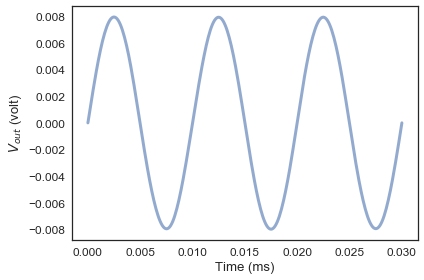

In [18]:
def plot_results(results):
    xs = results.V_out.index
    ys = results.V_out.values

    t_end = get_last_label(results)
    if t_end < 10:
        xs *= 1000
        xlabel = 'Time (ms)'
    else:
        xlabel = 'Time (s)'
        
    plot(xs, ys)
    decorate(xlabel=xlabel,
             ylabel='$V_{out}$ (volt)',
             legend=False)
    
plot_results(results)

And velocity as a function of time:

The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.
The solver successfully reached the end of the integration interval.


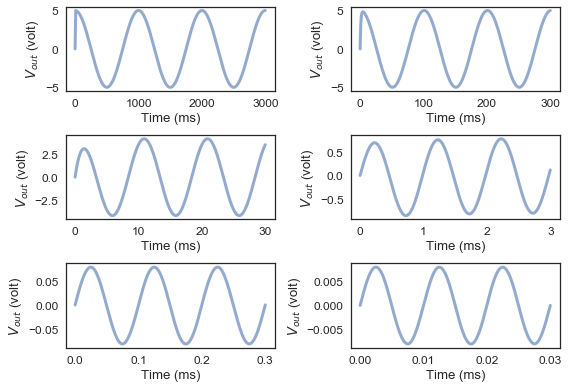

In [19]:
fs = [1, 10, 100, 1000, 10000, 100000]
for i, f in enumerate(fs):
    system = make_system(Params(params, f=f))
    ts = linspace(0, system.t_end, 301)
    results, details = run_ode_solver(system, slope_func, t_eval=ts)
    subplot(3, 2, i+1)
    plot_results(results)